### T12s are financial documents of Real Estate properties. We will build a simple RAG Application first and then experiment with fine-tuning an embedding model for Q&A task.

In [7]:
import os
os.getcwd()

'/content/drive/MyDrive/LLMs/Q&A'

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [8]:
%cd /content/drive/My Drive/LLMs/Q&A

/content/drive/My Drive/LLMs/Q&A


In [4]:
from PIL import Image
import requests

url = "https://huggingface.co/datasets/huggingface/cookbook-images/resolve/main/RAG_workflow.png"

img = Image.open(requests.get(url, stream=True).raw)
# Resize the image
resized_img = img.resize((700, 700))

# Optionally save the resized image
resized_img.save('resized_image.png', 'PNG')

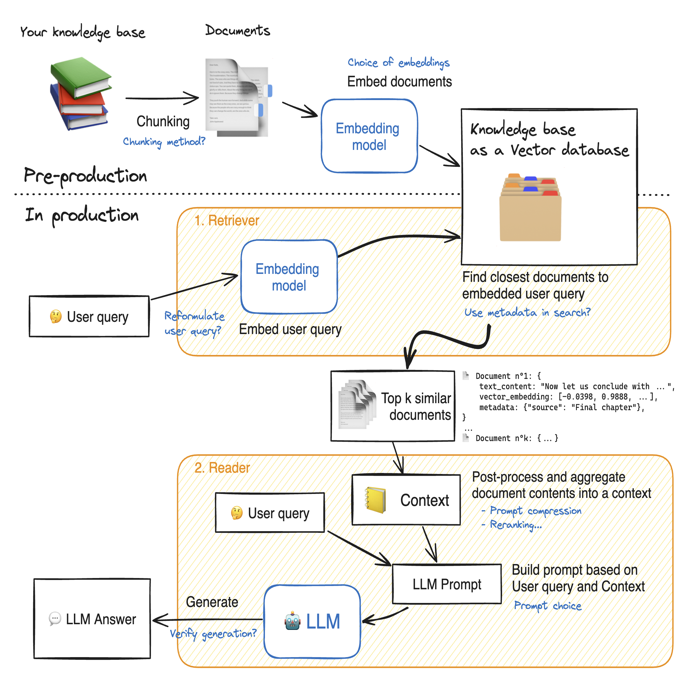

In [ ]:
# Optionally display the resized image inline (requires additional libraries)
from IPython.display import display
display(resized_img)

In [9]:
!python --version

Python 3.10.12


In [ ]:
#!pip install llama-index
#!pip install reportlab
#!pip install llama-index-embeddings-huggingface
#!pip install llama-index-vector-stores-chroma
#!pip install chromadb
#!pip install wandb
#!pip install llama-parse
#!pip install mistralai

In [5]:
files = !ls
files = list(files)
files = [item for item in files[0].strip().split()]
files

['Chroma', 'data', 'requirements.txt', 'resized_image.png', "'t12_q&a.ipynb'"]

In [ ]:
#!pip freeze > requirements.txt
if 'requirements.txt' in files:
  !pip install -r requirements.txt

In [36]:
import torch
import os
import pandas as pd
from llama_index.core import SimpleDirectoryReader, VectorStoreIndex, Document, Settings, StorageContext
from llama_index.vector_stores.chroma import ChromaVectorStore
from llama_parse import LlamaParse
from openpyxl import load_workbook
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
import chromadb
import wandb
from transformers import pipeline
from langchain.chains.question_answering import load_qa_chain
from langchain.chains import RetrievalQA
from langchain.vectorstores import Chroma
#from langchain_community.embeddings.sentence_transformer import (SentenceTransformerEmbeddings)
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.text_splitter import TokenTextSplitter, CharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
# create the open-source embedding function
"""
This is a sentence-transformers model: It maps sentences & paragraphs to a 384 dimensional dense vector space and can be used for tasks like clustering or semantic search.
"""
embedding_function = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

import instructor
from openai import OpenAI
from typing import Optional
from pydantic import BaseModel
from pydantic import Field
from mistralai.client import MistralClient
from instructor.function_calls import Mode

import nest_asyncio
nest_asyncio.apply()

from google.colab import userdata

In [ ]:
# # create client and a new collection
# collection_name = "my_news"

# # If you have created the collection before, you need to delete the collection first
# if len(chroma_client.list_collections()) > 0 and collection_name in [chroma_client.list_collections()[0].name]:
#     chroma_client.delete_collection(name=collection_name)

# print(f"Creating collection: '{collection_name}'")
# collection = chroma_client.create_collection(name=collection_name)

# db = chromadb.PersistentClient(path="./chroma_db")
# chroma_collection = db.create_collection("t12_financials")

In [32]:
f"GPU count: {torch.cuda.device_count()}"

'GPU count: 1'

In [12]:
gpu_names = [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())]
print("GPU(s) available: {}".format(gpu_names))

GPU(s) available: ['Tesla T4']


In [13]:
dir_path = "/content/drive/My Drive/LLMs/Q&A/data/"

for file in os.listdir(dir_path):
  print(file)

The_Orion_Alex.xlsx
The_Orion_Alex.pdf
12_Month_Statement_rfcascaa_Accrual.xlsx
12_Month_Statement_p2140_Accrual.xlsx
12_Month_Statement_logan_Accrual.xlsx
12_Month_Statement_konrad_Accrual.xlsx
12_Month_Statement_harland_Accrual.xlsx
0Standard_ProfitandLoss_Trailing12Months.xlsx
cash_flow_12_month-20231115[AppFolio].xlsx
cash_flow_12_month-20231115[AppFolio].pdf
12_Month_Statement_rfcorela_Accrual.xlsx
12_Month_Statement_rfcascaa_Accrual.pdf
12_Month_Statement_logan_Accrual.pdf
12_Month_Statement_rfcorela_Accrual.pdf
12_Month_Statement_konrad_Accrual.pdf
12_Month_Statement_harland_Accrual.pdf
12_Month_Statement_p2140_Accrual.pdf
0Standard_ProfitandLoss_Trailing12Months.pdf


Llamaindex seems to work better with parsing PDFs. So, let's convert .xlsx to .pdfs.

In [ ]:
def xlsx_to_pdf(input_file, output_file):
    # Load the Excel file
    wb = load_workbook(input_file)
    ws = wb.active

    # Create a PDF
    c = canvas.Canvas(output_file, pagesize=letter)
    y = 800  # Initial y-coordinate for writing text

    for row in ws.iter_rows():
        x = 50  # Initial x-coordinate for writing text
        for cell in row:
            c.drawString(x, y, str(cell.value))
            x += 100  # Adjust this value according to your needs
        y -= 20  # Adjust this value according to your needs

    c.save()

In [ ]:
def convert_excel_to_pdf(dir_path):

  for file in os.listdir(dir_path):
    if file.endswith('.xlsx'):
      input_file = os.path.join(dir_path, file)
      output_file = os.path.splitext(input_file)[0] + '.pdf'

      xlsx_to_pdf(input_file, output_file)
      print(f"Converted {file} to PDF.")

In [ ]:
convert_excel_to_pdf(dir_path)

#### Let's start with a simple RAG architecture

In [14]:
def load_chunk_persist_pdf() -> Chroma:
    pdf_folder_path = "/content/drive/My Drive/LLMs/Q&A/data/"
    documents = []
    # Load each .pdf doc in a document list
    for file in os.listdir(pdf_folder_path):
        if file.endswith('.pdf'):
            pdf_path = os.path.join(pdf_folder_path, file)
            loader = PyPDFLoader(pdf_path)
            documents.extend(loader.load())

    # chunk
    #text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=10)
    #chunked_documents = text_splitter.split_documents(documents)

    # Naively chunk the SEC filing by tokens
    token_splitter = TokenTextSplitter(chunk_size=1000, chunk_overlap=100)
    docs = token_splitter.split_documents(documents)

    # Create a vector store / DB
    client = chromadb.Client()
    collection_name = "t12_financials"

    if len(client.list_collections()) > 0 and collection_name in [client.list_collections()[0].name]:
      client.delete_collection(name=collection_name)
    else:
        print(f"Creating collection: '{collection_name}'")
        collection = client.create_collection(name=collection_name)

    # Create a vectorDB
    vectordb = Chroma.from_documents(
        documents=docs,
        embedding=embedding_function,
        persist_directory="/content/drive/My Drive/LLMs/Q&A/Chroma"
    )

    vectordb.persist()
    return vectordb

In [15]:
vdb = load_chunk_persist_pdf()

Creating collection: 't12_financials'


In [16]:
# load from disk
vdb = Chroma(persist_directory="./Chroma", embedding_function=embedding_function)
vdb

#### Retrive the Context for the Query

In [33]:
query = "What is the  Section 8 Rent Income in March 2023 at The Tillicum Apartments?"

# Get documents from vectorDB
k = 5
top_k_docs = vdb.similarity_search(query, k)

context = "\n".join([doc.page_content for doc in top_k_docs])
f"Length: {len(context)} Context: {context}"

"Length: 6651 Context: Cash Flow - 12 Month\nExported On: 2023-11-15 14:55:28 -0800\nAmoriss CRG\nProperties: Tillicum Apartments - 2101-2113 W 7th St. The Dalles, OR 97058\nPeriod Range: Jan 2023 to Dec 2023\nAccounting Basis: Accrual\nLevel of Detail: Detail View\nInclude Zero Balance GL Accounts: No\nAccount Number Account Name Jan 2023\nOperating Income & Expense\n    Income\n        RENTS\n4100             Rent Income 18,943.00\n4105             Section 8 Rent 3,771.00\n4106             Pet Rent 104.00\n        Total RENTS 22,818.00\n4320         Tenant Paid - Repairs 0.00\n4330         Lockout Charge 140.00\n        FEES\n4410             NSF Fees Collected 0.00\n4440             Application Fee Income -210.00\n4460             Late Fee 75.00\n4485             Lease Buy-out Fee 0.00\n        Total FEES -135.00\nCash Flow - 12 Month\nExported On: 2023-11-15 14:55:28 -0800\nAmoriss CRG\nProperties: Tillicum Apartments - 2101-2113 W 7th St. The Dalles, OR 97058\nPeriod Range: Jan 20

#### Answer and structure output with Instructor

In [34]:
# Define our data model
class Financials(BaseModel):
      Property: Optional[str] = Field(description="Property Name", default=None)
      period: Optional[str] = Field(description="The financial period like Oct 2023", default=None)
      Item: Optional[str] = Field(description="Line-item on the T12 Financial statement", default=None)
      Header: Optional[str] = Field(description="Category", default=None)
      Sub_Header: Optional[str] = Field(description="Sub-Category", default=None)
      dollar_value: Optional[str] = Field(description="currency", default=None)

# Instantiate instructor and enable `response_model` in chat call
client = MistralClient(api_key=os.environ['MISTRAL_API_KEY'])
patched_chat = instructor.patch(create=client.chat, mode=Mode.MISTRAL_TOOLS)

resp = patched_chat(
    model="mistral-small-latest",
    response_model=Financials,
    messages=[
        {"role": "system", "content": "You are an expert financial assistant that reads Real Estate Property P&L documents and answers questions."},
        {"role": "user", "content": f"Question: {query} Context: {context}"},
    ],
)

print(resp)
#print(resp.choices[0].message.content)

Property='The Tillicum Apartments' period='March 2023' Item='Section 8 Rent' Header=None Sub_Header=None dollar_value=None


The response is not quite what we are looking for. It seems to not realize the exact positioning / row and column table format. Let's try a few different approaches that builds on this naive-RAG.

A couple of promising approaches to try:

- https://blog.langchain.dev/semi-structured-multi-modal-rag/
- https://www.llamaindex.ai/blog/introducing-llamacloud-and-llamaparse-af8cedf9006b
- https://github.com/run-llama/llama_parse/blob/main/examples/demo_advanced.ipynb
- https://github.com/langchain-ai/langchain/blob/master/cookbook/Semi_Structured_RAG.ipynb

Feedback from Nico:

1. Use the exact same embedding function.
2. PDF Format - detect the tables. Print - fit to width.
3. Pre-process the pdf page and use markdown format to parse the table. Clean table. https://camelot-py.readthedocs.io/en/master